In [28]:
import pandas as pd
import spacy

import plotly.express as px
import matplotlib.pyplot as plt
import os

In [7]:
folder_path = 'your_folder_path'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
df_list = []

In [16]:
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')
    # Add a column for the filename (without extension)
    df['source_file'] = os.path.splitext(file)[0]
    # Set MultiIndex with the filename as outer index
    df.set_index('source_file', append=True, inplace=True)
    df_list.append(df)

df_list

[                                                          ReviewText  \
      source_file                                                       
 0    EA_Sports_FC              this game is ok but fifa 23 is better   
 1    EA_Sports_FC                                          good game   
 2    EA_Sports_FC                                      Absolute ♥♥♥♥   
 3    EA_Sports_FC                                                lll   
 4    EA_Sports_FC                                   I sccore bangers   
 ...                                                              ...   
 5905 EA_Sports_FC                leeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee   
 5906 EA_Sports_FC  I've been playing FIFA since 98. There's never...   
 5907 EA_Sports_FC                                 best fifa after 18   
 5908 EA_Sports_FC                              this is the best game   
 5909 EA_Sports_FC  great game, ignore the haters.still p2w if you...   
 
                             Review  ReviewLength

In [17]:
combined_df = pd.concat(df_list)
combined_df = combined_df.reorder_levels(['source_file'] + [lvl for lvl in combined_df.index.names if lvl != 'source_file'])

In [18]:
combined_df

ReviewText  \
source_file                                                          
EA_Sports_FC 0               this game is ok but fifa 23 is better   
             1                                           good game   
             2                                       Absolute ♥♥♥♥   
             3                                                 lll   
             4                                    I sccore bangers   
...                                                            ...   
Valheim      65                          Early Access ReviewGoodly   
             66  Early Access ReviewThis game changed the way i...   
             67  Early Access Reviewbetter version of minecraft...   
             68  Early Access ReviewA fun video game to play wi...   
             69  Early Access Reviewi love this game despite i ...   

                          Review  ReviewLength PlayHours  DatePosted  
source_file                                                           
EA_Sports_FC 0       Recommended            29      8.2   14-04-2024  
             1       Recommended             8      5.8   14-04-2024  
             2   Not Recommended            12     31.1   14-04-2024  
             3       Recommended             3      8.3   14-04-2024  
             4       Recommended            14     24.3   14-04-2024  
...                          ...           ...       ...         ...  
Valheim      65      Recommended            23     24.5          NaN  
             66      Recommended            66    377.2          NaN  
             67      Recommended            68     67.2          NaN  
             68      Recommended            47     30.6          NaN  
             69      Recommended            69     17.9          NaN  

[118567 rows x 5 columns]

<h4>Text Preprocessing</h4>

In [41]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define preprocessing function
def preprocess_with_spacy(text):
    if pd.isna(text):
        return ""

    text = text.lower().replace("early access review", "")
    
    # Apply spaCy pipeline
    doc = nlp(text.lower())  # Lowercase early
    
    tokens = [
        token.lemma_  # Lemmatize
        for token in doc
        if not token.is_stop            # Remove stopwords
        and not token.is_punct          # Remove punctuation
        and not token.is_space          # Remove spaces
        and not token.like_num          # Remove numbers
        and token.is_alpha              # Keep only alphabetic tokens
    ]
    
    return ' '.join(tokens)

# Example: Apply to a DataFrame column
combined_df['cleaned_review'] = combined_df['ReviewText'].apply(preprocess_with_spacy)


In [42]:
combined_df

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,cleaned_review
source_file,,,,,,
EA_Sports_FC,this game is ok but fifa 23 is better,Recommended,29,8.2,14-04-2024,game ok fifa well
EA_Sports_FC,good game,Recommended,8,5.8,14-04-2024,good game
EA_Sports_FC,Absolute ♥♥♥♥,Not Recommended,12,31.1,14-04-2024,absolute
EA_Sports_FC,lll,Recommended,3,8.3,14-04-2024,lll
EA_Sports_FC,I sccore bangers,Recommended,14,24.3,14-04-2024,sccore banger
...,...,...,...,...,...,...
Valheim,Early Access ReviewGoodly,Recommended,23,24.5,NaN,goodly
Valheim,Early Access ReviewThis game changed the way i...,Recommended,66,377.2,NaN,game change way look game check box
Valheim,Early Access Reviewbetter version of minecraft...,Recommended,68,67.2,NaN,well version minecraft difficult good way


In [48]:
import re

def clean_text(text):
    text = str(text).lower()                            # Lowercase
    text = re.sub(r'http\S+', '', text)                 # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)                # Keep only letters and spaces
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)           # Reduce repeating characters: e.g., waaaaay → waay
    text = re.sub(r'\s+', ' ', text).strip()            # Remove extra whitespace
    return text

# Apply cleaning
combined_df['cleaned_review'] = combined_df['cleaned_review'].apply(clean_text)


In [49]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(combined_df['cleaned_review'])
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())


In [50]:
bow_df

,aa,aabiliyorsan,aada,aadaasdadaddasdsadasdadada,aaddadadadasdadadadasdasd,aaggh,aagghh,aah,aahh,aaim,...,zven,zwalic,zweifeln,zweite,zwingt,zxc,zy,zz,zzgg,zzt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,       # Optional: limit vocab size
    min_df=2,                # Optional: ignore very rare words
    token_pattern=r'\b\w+\b' # Ensures words like "ve", "waifus" are tokenized
)

# Fit and transform the text column
X_tfidf = tfidf_vectorizer.fit_transform(combined_df['cleaned_review'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [52]:
tfidf_df

,aa,aabiliyorsan,aada,aadaasdadaddasdsadasdadada,aaddadadadasdadadadasdasd,aaggh,aagghh,aah,aahh,aaim,...,zven,zwalic,zweifeln,zweite,zwingt,zxc,zy,zz,zzgg,zzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Sentiment Analysis</h3>

In [54]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

combined_df['sentiment'] = combined_df['cleaned_review'].apply(vader_sentiment)


In [60]:
combined_df

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,cleaned_review,sentiment
source_file,,,,,,,
EA_Sports_FC,this game is ok but fifa 23 is better,Recommended,29,8.2,14-04-2024,game ok fifa well,positive
EA_Sports_FC,good game,Recommended,8,5.8,14-04-2024,good game,positive
EA_Sports_FC,Absolute ♥♥♥♥,Not Recommended,12,31.1,14-04-2024,absolute,neutral
EA_Sports_FC,lll,Recommended,3,8.3,14-04-2024,ll,neutral
EA_Sports_FC,I sccore bangers,Recommended,14,24.3,14-04-2024,sccore banger,neutral
...,...,...,...,...,...,...,...
Valheim,Early Access ReviewGoodly,Recommended,23,24.5,NaN,goodly,neutral
Valheim,Early Access ReviewThis game changed the way i...,Recommended,66,377.2,NaN,game change way look game check box,neutral
Valheim,Early Access Reviewbetter version of minecraft...,Recommended,68,67.2,NaN,well version minecraft difficult good way,positive


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(combined_df['cleaned_review'])


In [62]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(combined_df['sentiment'])  # 0=negative, 1=neutral, 2=positive


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

    negative       0.95      0.85      0.90      3522
     neutral       0.92      0.97      0.94      6525
    positive       0.97      0.97      0.97     13667

    accuracy                           0.95     23714
   macro avg       0.95      0.93      0.94     23714
weighted avg       0.95      0.95      0.95     23714



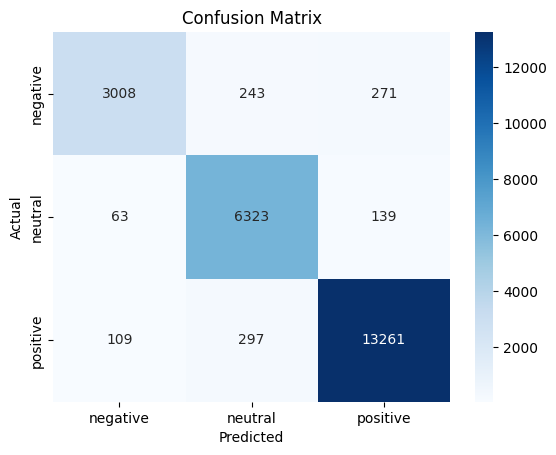

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [67]:
combined_df.to_csv('steam_reviews.csv')